# This notebook studies the relationship between fingerprints and sessions
## (Figure 10 of the paper)

## We want to know how many sessions per fingerprints and viceversa

### Import dataset

In [1]:
import pandas as pd
predicted_corpus = pd.read_parquet(f"../1.Dataset/Inference_with_predictions/logprecis_predictions.parquet")
predicted_corpus.head(2)

,session_id,sequence_words,sequence_predictions
0,0,"[enable, ;, system, ;, shell, ;, sh, ;, cat, /...","[Discovery, Discovery, Discovery, Discovery, D..."
1,1,"[enable, ;, system, ;, shell, ;, sh, ;, cat, /...","[Discovery, Discovery, Discovery, Discovery, D..."


Create fingerprints

In [2]:
predicted_corpus["fingerprints"] = predicted_corpus["sequence_predictions"].apply(lambda prediction: " -- ".join(prediction))
predicted_corpus["sessions"] = predicted_corpus["sequence_words"].apply(lambda command: " ".join(command))

### How many unique sequences of predicted classes?

In [3]:
print(f"Number of unique model's predictions: {predicted_corpus.fingerprints.nunique():,}")

Number of unique model's predictions: 1,673


### Obtain ECDF

#### This is the number of sessions associated per fingerprint

In [4]:
import numpy as np
sessions_x_fingerprints = predicted_corpus.value_counts("fingerprints").reset_index().rename({0:"associated_sessions"}, axis = 1)
pdf_associated_sessions = sessions_x_fingerprints.value_counts("associated_sessions").sort_index()
cdf_associated_sessions = np.cumsum(pdf_associated_sessions)/np.sum(pdf_associated_sessions)
cdf_associated_sessions = cdf_associated_sessions.reset_index(name = "cdf")
cdf_associated_sessions.head(2)

,associated_sessions,cdf
0,1,0.571429
1,2,0.696354


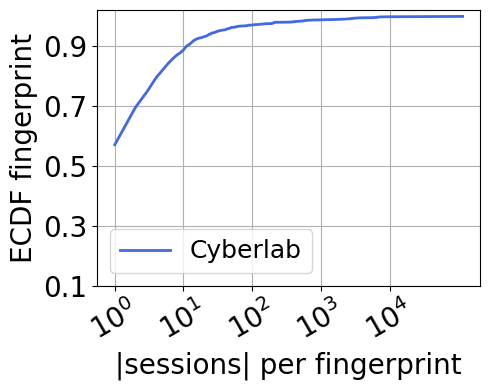

In [5]:
import matplotlib.pyplot as plt 

fig, (ax_1) = plt.subplots(1, figsize=(5,4))
fontsize = 20
ax_1.plot(cdf_associated_sessions.associated_sessions, cdf_associated_sessions.cdf, 
          linewidth = 2, color = "royalblue", label = "Cyberlab")

ax_1.set_xlabel('|sessions| per fingerprint', fontsize = fontsize)
ax_1.set_xscale("log")
ax_1.set_ylabel('ECDF fingerprint', fontsize = fontsize)
ax_1.yaxis.set_tick_params(labelsize=fontsize)
ax_1.xaxis.set_tick_params(labelsize=fontsize, rotation = 30)
ax_1.set_xticks([1, 10, 100, 1000, 10000])
ax_1.set_yticks(np.arange(.1, 1.1, .2))
ax_1.legend(fontsize = fontsize - 2, loc = "lower left")
ax_1.grid()
plt.tight_layout()

#### Now obtain inverse information: 
Which percentage of the original corpus I am covering only with the fingerprints with 1 associated session?

Of course here the idea is: if the percentage is not critical, I can exclude them as noisy and still be descriptive of the dataset!

In [6]:
merged_corpus = predicted_corpus.merge(sessions_x_fingerprints, on = "fingerprints").sort_values(by = "associated_sessions")
merged_corpus = merged_corpus[["fingerprints", "sessions", "associated_sessions"]]
merged_corpus.head(2)

,fingerprints,sessions,associated_sessions
233034,Discovery -- Discovery -- Discovery -- Discove...,cat /proc/cpuinfo | grep name | wc -l ; echo -...,1
224264,Discovery -- Discovery -- Discovery -- Discove...,LC_ALL=C cat /etc/rc.local /etc/rc.d/rc.local ...,1


In [8]:
counter_sessions_per_fingerprints = merged_corpus.groupby("associated_sessions")["sessions"].count()\
                                        .reset_index().rename({"associated_sessions": "sessions_x_fingerprint", "sessions":"n_sessions"}, axis = 1)

In [9]:
counter_sessions_per_fingerprints["cdf_occurrences"] = 1 - np.cumsum(counter_sessions_per_fingerprints["n_sessions"])/np.sum(counter_sessions_per_fingerprints["n_sessions"])

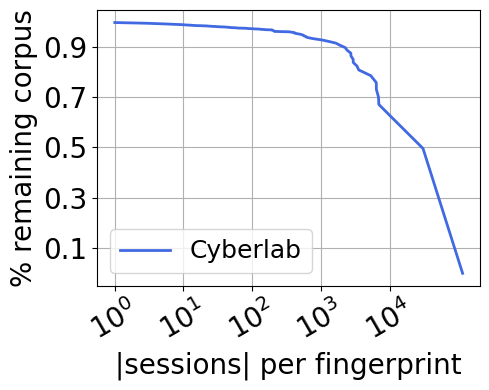

In [10]:
fig, (ax_2) = plt.subplots(1, figsize=(5,4))

ax_2.plot(counter_sessions_per_fingerprints["sessions_x_fingerprint"], counter_sessions_per_fingerprints["cdf_occurrences"], \
          linewidth = 2, color = "royalblue", label = "Cyberlab")
ax_2.set_xlabel('|sessions| per fingerprint', fontsize = fontsize)
ax_2.set_xscale("log")
ax_2.set_ylabel('% remaining corpus', fontsize = fontsize)
ax_2.yaxis.set_tick_params(labelsize=fontsize)
ax_2.xaxis.set_tick_params(labelsize=fontsize, rotation = 30)
ax_2.set_xticks([1, 10, 100, 1000, 10000])
ax_2.set_yticks(np.arange(.1, 1.1, .2))
ax_2.legend(fontsize = fontsize - 2, loc = "lower left")
ax_2.grid()
plt.tight_layout()

Message here is: if I do not consider all fingerprints with less than 10 sessions associated, I'm **still considering >95% of the corpus**